# 6-2 模型训练的3种方法

Pytorch通常需要用户自定义编写训练循环, 训练循环的代码风格因人而异。

一般有三种形式：
1. 脚本形式循环
2. 函数形式循环
3. 类形式循环

下面以minist数据集训练为例, 演示这三种训练模型的风格。

## 一、准备数据

In [1]:
import torch 
from torch import nn 
from torchkeras import summary,Model 

import torchvision 
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="./data/MINIST", train=True, download=True, transform=transform)
ds_valid = torchvision.datasets.MNIST(root="./data/MINIST", train=False, download=True, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True, num_workers=4)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, shuffle=True, num_workers=4)

print(len(ds_train))
print(len(ds_valid))

Widget Javascript not detected.  It may not be installed properly.


Extracting ./data/MINIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MINIST/MNIST/raw


Widget Javascript not detected.  It may not be installed properly.


Extracting ./data/MINIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MINIST/MNIST/raw



Widget Javascript not detected.  It may not be installed properly.


Extracting ./data/MINIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MINIST/MNIST/raw


Widget Javascript not detected.  It may not be installed properly.


Extracting ./data/MINIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MINIST/MNIST/raw
Processing...


/root/anaconda3/envs/pytorch1.6/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
60000
10000


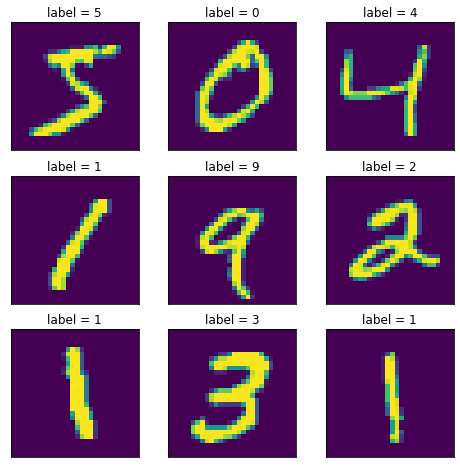

In [4]:
# 查看部分样本
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = ds_train[i]
    img = torch.squeeze(img)
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = {:d}".format(int(label)))  # 没有用target_transform
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 二、脚本风格
脚本风格的训练循环最为常见

In [5]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,10))

print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


In [6]:
summary(net,input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [7]:
import pandas as pd 
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred), dim=1).data
    return accuracy_score(y_true,y_pred_cls)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr = 0.01)
metric_func = accuracy
metric_name = "accuracy"

In [9]:
epochs = 3
log_step_freq = 100

dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_" + metric_name])
print("Starting Training.....")

for epoch in range(1, epochs+1):
    
    # 1. 训练循环
    net.train()  # 设置为训练模式
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        
        # 梯度清0
        optimizer.zero_grad()
        
        # 正向传播求损失
        y_pred = net(features)
        loss = loss_func(y_pred, labels)
        metric = metric_func(y_pred, labels)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别的日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    # 2. 验证循环
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
print('Finished Training...')  # 不等了

Starting Training.....
[step = 100] loss: 1.746, accuracy: 0.361
[step = 200] loss: 1.199, accuracy: 0.576
[step = 300] loss: 0.952, accuracy: 0.672
[step = 400] loss: 0.867, accuracy: 0.708
[step = 500] loss: 0.763, accuracy: 0.746
[step = 600] loss: 0.695, accuracy: 0.771
[step = 700] loss: 0.647, accuracy: 0.788
[step = 800] loss: 0.606, accuracy: 0.802
[step = 900] loss: 0.579, accuracy: 0.813
[step = 1000] loss: 0.550, accuracy: 0.823
[step = 1100] loss: 0.530, accuracy: 0.830
[step = 1200] loss: 0.513, accuracy: 0.837
[step = 1300] loss: 0.498, accuracy: 0.843
[step = 1400] loss: 0.487, accuracy: 0.847
[step = 1500] loss: 0.477, accuracy: 0.850
[step = 1600] loss: 0.471, accuracy: 0.853
[step = 1700] loss: 0.472, accuracy: 0.854
[step = 1800] loss: 0.467, accuracy: 0.856
[step = 1900] loss: 0.461, accuracy: 0.859
[step = 2000] loss: 0.453, accuracy: 0.862
[step = 2100] loss: 0.446, accuracy: 0.865
[step = 2200] loss: 0.437, accuracy: 0.868
[step = 2300] loss: 0.429, accuracy: 0.8

KeyboardInterrupt: 

### 三、函数风格

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [11]:
summary(net,input_shape=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [12]:
def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true,y_pred_cls)

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = nn.CrossEntropyLoss()
model.metric_func = accuracy
model.metric_name = "accuracy"

In [13]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

@torch.no_grad()  # 不记录梯度
def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()

In [14]:
# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)

(2.316053628921509, 0.0)

In [15]:
def train_model(model,epochs,dl_train,dl_valid,log_step_freq):

    metric_name = model.metric_name
    dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
    print("Start Training...")

    for epoch in range(1,epochs+1):  

        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features,labels) in enumerate(dl_train, 1):

            loss,metric = train_step(model,features,labels)

            # 打印batch级别日志
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:   
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))

        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features,labels) in enumerate(dl_valid, 1):

            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)

    print('Finished Training...')
    return dfhistory

In [16]:
epochs = 1
dfhistory = train_model(model,epochs,dl_train,dl_valid,log_step_freq = 1000)

Start Training...
[step = 1000] loss: 2.081, accuracy: 0.341
[step = 2000] loss: 1.437, accuracy: 0.557
[step = 3000] loss: 1.064, accuracy: 0.674

EPOCH = 1, loss = 0.898,accuracy  = 0.725, val_loss = 0.158, val_accuracy = 0.956
Finished Training...


### 三、类风格

In [18]:
import torchkeras
class CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
model = torchkeras.Model(CnnModel())
print(model)

Model(
  (net): CnnModel(
    (layers): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): AdaptiveMaxPool2d(output_size=(1, 1))
      (6): Flatten()
      (7): Linear(in_features=64, out_features=32, bias=True)
      (8): ReLU()
      (9): Linear(in_features=32, out_features=10, bias=True)
    )
  )
)


In [19]:
def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred),dim=1).data
    return accuracy_score(y_true.numpy(),y_pred_cls.numpy())

model.compile(loss_func = nn.CrossEntropyLoss(),
             optimizer= torch.optim.Adam(model.parameters(),lr = 0.02),
             metrics_dict={"accuracy":accuracy})

In [20]:
dfhistory = model.fit(1, dl_train = dl_train, dl_val=dl_valid, log_step_freq=1000) 

Start Training ...

================================================================================2020-09-27 16:35:10
{'step': 1000, 'loss': 2.307, 'accuracy': 0.112}
{'step': 2000, 'loss': 2.306, 'accuracy': 0.11}
{'step': 3000, 'loss': 2.306, 'accuracy': 0.108}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 2.306 |  0.108   |  2.303   |    0.101     |
+-------+-------+----------+----------+--------------+

================================================================================2020-09-27 16:36:39
Finished Training...
